In [1]:
# Dataset:
    # Simulated engine degradation under different combinations of operational conditions and modes 
    # Records several sensor channels to characterize fault evolution. Provided by NASA
    # https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/
    
# Approach:
    # Prognostics: predicting the time at which something will no longer perform it's indended function
    # Remaining Useful Life (RUL): continious target, number of useful cycles left on the engine --> Regression Exercise
    # Last 15 Cycles: binary target, represents whether the asset is in the last 15 cycles of life --> Classification Exercise
    # This approach predicts 'RUL' and 'Last 15 Cycles' by treating each time point independently
    
#Notebook:
    #Notebook based on:
    #https://www.kaggle.com/billstuart/predictive-maintenance-ml-iiot

# Developer: Pedro Moreno Sánchez (pedro.morenosanchez@seamk.fi)

In [2]:
# load necessary packages and view available data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
%matplotlib inline
sns.set()
#print(os.listdir("../input"))
# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [3]:
# the files did not contain headers. Here we create labels based on documentation
target_var = ['Target_Remaining_Useful_Life']
index_columns_names =  ['UnitNumber','Cycle']
op_settings_columns = ['Op_Setting_'+str(i) for i in range(1,4)]
sensor_columns =['Sensor_'+str(i) for i in range(1,22)]
column_names = index_columns_names + op_settings_columns + sensor_columns
print(column_names)

['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21']


In [4]:
# load data
train= pd.read_csv('PM_train.txt\PM_train.csv', sep=" ", header=None)
test = pd.read_csv('PM_test.txt\PM_test.csv', sep=" ", header=None)
print("train shape: ", train.shape, "test shape: ", test.shape)


train shape:  (20631, 28) test shape:  (13096, 28)


In [5]:
print(train.head())
print(train.dtypes)

   0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1  ...  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236 NaN NaN  
2  ...  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442 NaN NaN  
3  ...  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739 NaN NaN  
4  ...  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044 NaN NaN  

[5 rows x 28 columns]
0       int64
1       int64
2     float64
3     float64
4     float64


In [5]:
# drop NULL columns
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)
# name columns
train.columns = [column_names]
test.columns = [column_names]


In [9]:
train.columns = train.columns.get_level_values(0)
test.columns = test.columns.get_level_values(0)

train[train['UnitNumber'] == 1].head(5)

UnitNumber  Cycle  Op_Setting_1  Op_Setting_2  Op_Setting_3  Sensor_1  \
0           1      1       -0.0007       -0.0004         100.0    518.67   
1           1      2        0.0019       -0.0003         100.0    518.67   
2           1      3       -0.0043        0.0003         100.0    518.67   
3           1      4        0.0007        0.0000         100.0    518.67   
4           1      5       -0.0019       -0.0002         100.0    518.67   

   Sensor_2  Sensor_3  Sensor_4  Sensor_5  ...  Sensor_12  Sensor_13  \
0    641.82   1589.70   1400.60     14.62  ...     521.66    2388.02   
1    642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   
2    642.35   1587.99   1404.20     14.62  ...     522.42    2388.03   
3    642.35   1582.79   1401.87     14.62  ...     522.86    2388.08   
4    642.37   1582.85   1406.22     14.62  ...     522.19    2388.04   

   Sensor_14  Sensor_15  Sensor_16  Sensor_17  Sensor_18  Sensor_19  \
0    8138.62     8.4195       0.03        392       2388      100.0   
1    8131.49     8.4318       0.03        392       2388      100.0   
2    8133.23     8.4178       0.03        390       2388      100.0   
3    8133.83     8.3682       0.03        392       2388      100.0   
4    8133.80     8.4294       0.03        393       2388      100.0   

   Sensor_20  Sensor_21  
0      39.06    23.4190  
1      39.00    23.4236  
2      38.95    23.3442  
3      38.88    23.3739  
4      38.90    23.4044  

[5 rows x 26 columns]

In [10]:
# this section calculates Remaining Useful Life (RUL) in T-minus notation for the training data
# find the last cycle per unit number
max_cycle = train.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']
max_cycle

UnitNumber  MaxOfCycle
0            1         192
1            2         287
2            3         179
3            4         189
4            5         269
..         ...         ...
95          96         336
96          97         202
97          98         156
98          99         185
99         100         200

[100 rows x 2 columns]

In [11]:
# merge the max cycle back into the original frame
train_merged = train.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')

In [12]:

# calculate RUL for each row
Target_Remaining_Useful_Life = train_merged["MaxOfCycle"] - train_merged["Cycle"]
train_with_target = train_merged["Target_Remaining_Useful_Life"] = Target_Remaining_Useful_Life
# remove unnecessary column
train_with_target = train_merged.drop("MaxOfCycle", axis=1)
train_with_target[train_with_target['UnitNumber'] == 1].head(5)

UnitNumber  Cycle  Op_Setting_1  Op_Setting_2  Op_Setting_3  Sensor_1  \
0           1      1       -0.0007       -0.0004         100.0    518.67   
1           1      2        0.0019       -0.0003         100.0    518.67   
2           1      3       -0.0043        0.0003         100.0    518.67   
3           1      4        0.0007        0.0000         100.0    518.67   
4           1      5       -0.0019       -0.0002         100.0    518.67   

   Sensor_2  Sensor_3  Sensor_4  Sensor_5  ...  Sensor_13  Sensor_14  \
0    641.82   1589.70   1400.60     14.62  ...    2388.02    8138.62   
1    642.15   1591.82   1403.14     14.62  ...    2388.07    8131.49   
2    642.35   1587.99   1404.20     14.62  ...    2388.03    8133.23   
3    642.35   1582.79   1401.87     14.62  ...    2388.08    8133.83   
4    642.37   1582.85   1406.22     14.62  ...    2388.04    8133.80   

   Sensor_15  Sensor_16  Sensor_17  Sensor_18  Sensor_19  Sensor_20  \
0     8.4195       0.03        392       2388      100.0      39.06   
1     8.4318       0.03        392       2388      100.0      39.00   
2     8.4178       0.03        390       2388      100.0      38.95   
3     8.3682       0.03        392       2388      100.0      38.88   
4     8.4294       0.03        393       2388      100.0      38.90   

   Sensor_21  Target_Remaining_Useful_Life  
0    23.4190                           191  
1    23.4236                           190  
2    23.3442                           189  
3    23.3739                           188  
4    23.4044                           187  

[5 rows x 27 columns]

C:\Users\k5000751\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


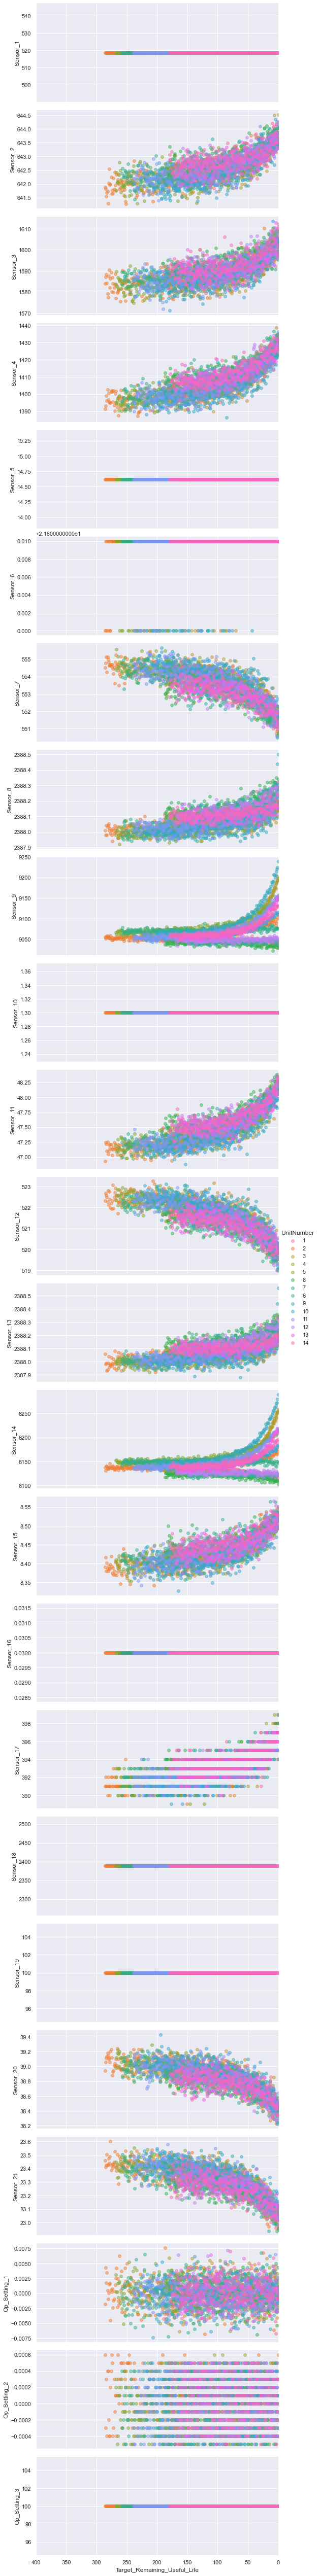

In [13]:
# use seaborn to visualize features to target (RUL)
explore = sns.PairGrid(data=train_with_target.query('UnitNumber < 15') ,
                 x_vars=target_var,
                 y_vars=sensor_columns + op_settings_columns,
                 hue="UnitNumber", size=3, aspect=2.5)
explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.set(xlim=(400,0))
explore = explore.add_legend()

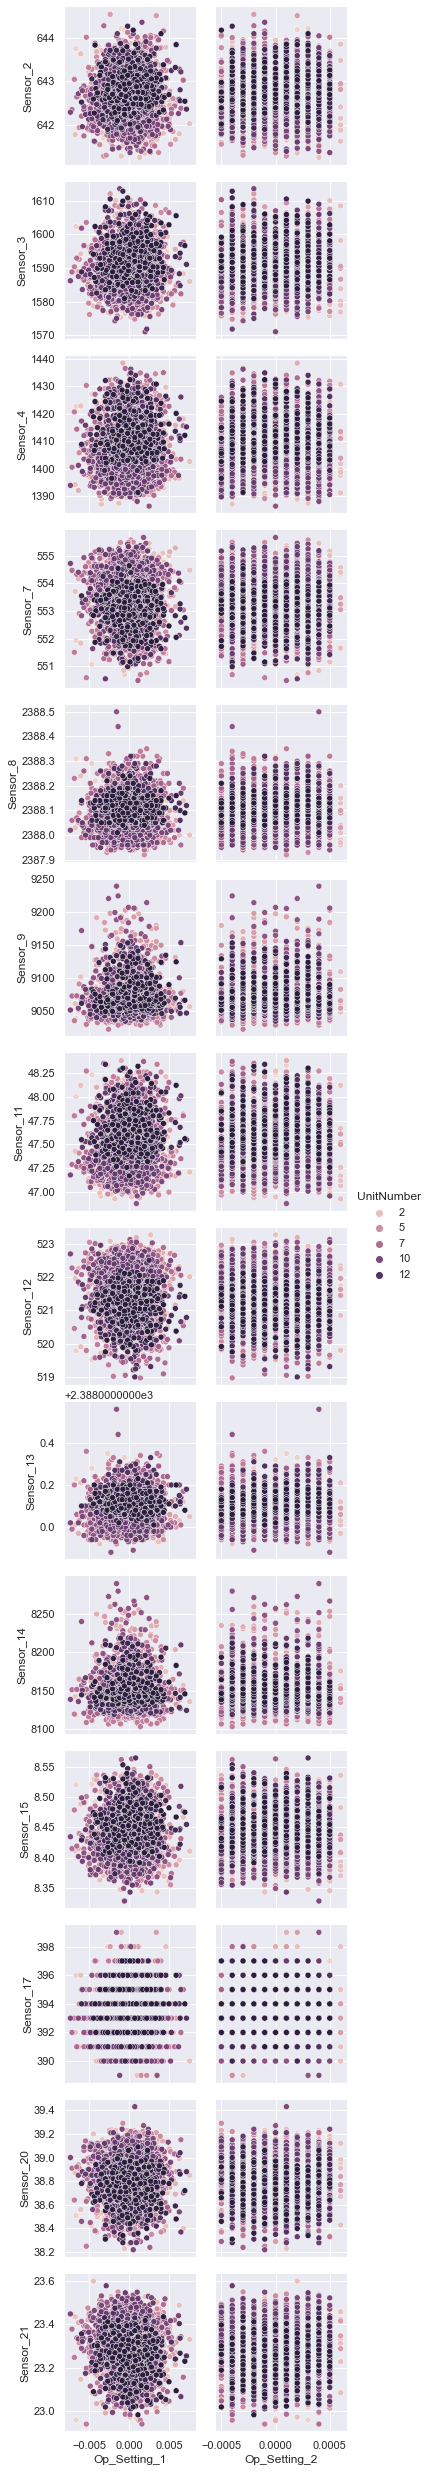

In [14]:
# operational setting 3 is stable, let's visualize op setting 1 and 2 against some of the most active sensors
g = sns.pairplot(data=train_with_target.query('UnitNumber < 15'),
                 x_vars=["Op_Setting_1","Op_Setting_2"],
                 y_vars=["Sensor_2", "Sensor_3", "Sensor_4", "Sensor_7", "Sensor_8", "Sensor_9", "Sensor_11", "Sensor_12", "Sensor_13", "Sensor_14", "Sensor_15", "Sensor_17", "Sensor_20", "Sensor_21"],
                 hue="UnitNumber", aspect=1)

In [15]:
# now it's time to clear out target leakage
print(train_with_target.shape)
leakage_to_drop = ['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3']  
train_no_leakage = train_with_target.drop(leakage_to_drop, axis = 1)
print(train_no_leakage.shape)


(20631, 27)
(20631, 22)


In [16]:
# set up features and target variable 
y = train_no_leakage['Target_Remaining_Useful_Life']
X = train_no_leakage.drop(['Target_Remaining_Useful_Life'], axis = 1)

In [17]:
# I like to use a simple random forest to determine some of the most important/meaningful features. Can be used as feature selection
# create an exhuastive random forest (200 trees up to 15 levels deep)
from sklearn import ensemble
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
single_rf.fit(X, y)
y_pred = single_rf.predict(X)
print("complete")

complete


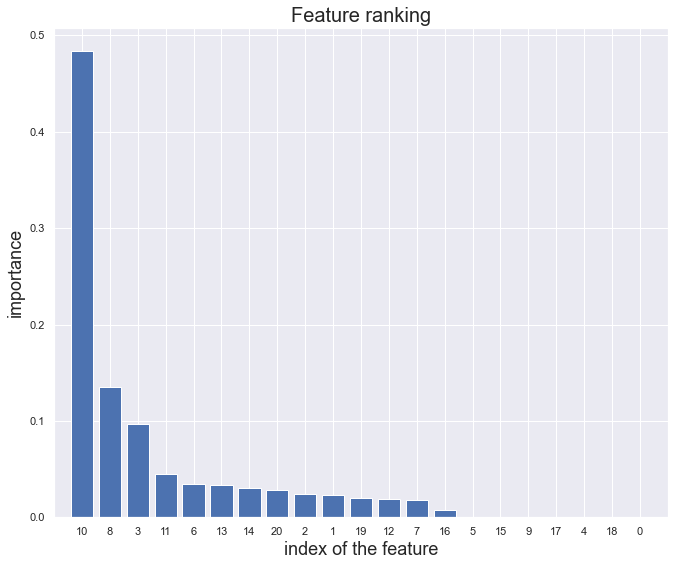

Sensor_11    0.483372
Sensor_9     0.135095
Sensor_4     0.097162
Sensor_12    0.044909
Sensor_7     0.034436
Sensor_14    0.033587
Sensor_15    0.030271
Sensor_21    0.027977
Sensor_3     0.024597
Sensor_2     0.023624
dtype: float64


In [18]:
# graph feature importance
import matplotlib.pyplot as plt
importances = single_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices) #feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()
# list feature importance
important_features = pd.Series(data=single_rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features.head(10))

In [19]:
# based on the graphs as well as random forest feature importance, I will exclude sensors without much valuable information
print(train_no_leakage.shape)
vars_to_drop = ["Sensor_"+str(i) for i in [5, 15, 9, 17, 4, 18]]
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
print(train_final.shape)

(20631, 22)
(20631, 16)


In [20]:
# identify categorical and numeric fields
from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)
#There is no categorical fields

[]


In [21]:
# create dummy variables (if any categorical fields)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)

In [22]:
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
y = numeric['Target_Remaining_Useful_Life']
X = numeric.drop(['Target_Remaining_Useful_Life'], axis = 1)

Sensor_1
Sensor_2
Sensor_3
Sensor_6
Sensor_7
Sensor_8
Sensor_10
Sensor_11
Sensor_12
Sensor_13
Sensor_14
Sensor_16
Sensor_19
Sensor_20
Sensor_21
Target_Remaining_Useful_Life


In [23]:
# random forest regression
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn.ensemble import RandomForestRegressor
rf = ensemble.RandomForestRegressor()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
print(optimized_rf.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_rf.predict(X_test)
print("Random Forest Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Random Forest Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Random Forest r-squared: ", r2_score(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Pipeline(steps=[('standardize', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=10))])
Random Forest Mean Squared Error:  1767.0672730644417
Random Forest Mean Absolute Error:  29.845423516303203
Random Forest r-squared:  0.626110838845705


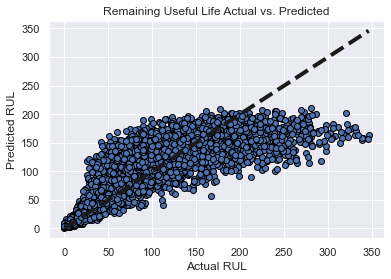

In [24]:
# plot actual vs predicted Remaining Useful Life for the best model (GBM)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

In [25]:
# now let's look at turning this into a classification solution -> can we confidently identify when an asset is within its last 15 cycles?
# generate label columns for training data
cycles = 15
train_no_leakage['Target_15_Cycles'] = np.where(train_no_leakage['Target_Remaining_Useful_Life'] <= cycles, 1, 0 )
train_no_leakage.tail(5)

Sensor_1  Sensor_2  Sensor_3  Sensor_4  Sensor_5  Sensor_6  Sensor_7  \
20626    518.67    643.49   1597.98   1428.63     14.62     21.61    551.43   
20627    518.67    643.54   1604.50   1433.58     14.62     21.61    550.86   
20628    518.67    643.42   1602.46   1428.18     14.62     21.61    550.94   
20629    518.67    643.23   1605.26   1426.53     14.62     21.61    550.68   
20630    518.67    643.85   1600.38   1432.14     14.62     21.61    550.79   

       Sensor_8  Sensor_9  Sensor_10  ...  Sensor_14  Sensor_15  Sensor_16  \
20626   2388.19   9065.52        1.3  ...    8137.60     8.4956       0.03   
20627   2388.23   9065.11        1.3  ...    8136.50     8.5139       0.03   
20628   2388.24   9065.90        1.3  ...    8141.05     8.5646       0.03   
20629   2388.25   9073.72        1.3  ...    8139.29     8.5389       0.03   
20630   2388.26   9061.48        1.3  ...    8137.33     8.5036       0.03   

       Sensor_17  Sensor_18  Sensor_19  Sensor_20  Sensor_21  \
20626        397       2388      100.0      38.49    22.9735   
20627        395       2388      100.0      38.30    23.1594   
20628        398       2388      100.0      38.44    22.9333   
20629        395       2388      100.0      38.29    23.0640   
20630        396       2388      100.0      38.37    23.0522   

       Target_Remaining_Useful_Life  Target_15_Cycles  
20626                             4                 1  
20627                             3                 1  
20628                             2                 1  
20629                             1                 1  
20630                             0                 1  

[5 rows x 23 columns]

In [34]:
# based on the graphs as well as random forest feature importance, I will exclude sensors without much valuable information
print(train_no_leakage.shape)
vars_to_drop = ["Sensor_"+str(i) for i in [5, 15, 9, 17, 4, 18]]
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
target_to_drop = ['Target_Remaining_Useful_Life']
train_final = train_final.drop(target_to_drop, axis = 1)
print(train_final.shape)
train_final.tail()

(20631, 23)
(20631, 16)


Sensor_1  Sensor_2  Sensor_3  Sensor_6  Sensor_7  Sensor_8  Sensor_10  \
20626    518.67    643.49   1597.98     21.61    551.43   2388.19        1.3   
20627    518.67    643.54   1604.50     21.61    550.86   2388.23        1.3   
20628    518.67    643.42   1602.46     21.61    550.94   2388.24        1.3   
20629    518.67    643.23   1605.26     21.61    550.68   2388.25        1.3   
20630    518.67    643.85   1600.38     21.61    550.79   2388.26        1.3   

       Sensor_11  Sensor_12  Sensor_13  Sensor_14  Sensor_16  Sensor_19  \
20626      48.07     519.49    2388.26    8137.60       0.03      100.0   
20627      48.04     519.68    2388.22    8136.50       0.03      100.0   
20628      48.09     520.01    2388.24    8141.05       0.03      100.0   
20629      48.39     519.67    2388.23    8139.29       0.03      100.0   
20630      48.20     519.30    2388.26    8137.33       0.03      100.0   

       Sensor_20  Sensor_21  Target_15_Cycles  
20626      38.49    22.9735                 1  
20627      38.30    23.1594                 1  
20628      38.44    22.9333                 1  
20629      38.29    23.0640                 1  
20630      38.37    23.0522                 1

In [35]:
# identify categorical and numeric fields
from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)

[]


In [36]:

# create dummy variables (if any categorical fields)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
y = numeric['Target_15_Cycles']
X = numeric.drop(['Target_15_Cycles'], axis = 1)

Sensor_1
Sensor_2
Sensor_3
Sensor_6
Sensor_7
Sensor_8
Sensor_10
Sensor_11
Sensor_12
Sensor_13
Sensor_14
Sensor_16
Sensor_19
Sensor_20
Sensor_21
Target_15_Cycles


In [37]:
# random forest classification
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
rf = ensemble.RandomForestClassifier()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 25, 50]
my_max_depth = [8, 9, 10, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
y_pred_proba = optimized_rf.predict_proba(X_test)[:, 1]
y_pred = optimized_rf.predict(X_test)
print(optimized_rf.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Pipeline(steps=[('standardize', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=12, min_samples_leaf=2))])


Confusion Matrix:
[[3788   54]
 [  40  245]]
Random Forest Accuracy: 97.7%
Random Forest Precision: 81.9%
Random Forest Recall: 86.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3842
           1       0.82      0.86      0.84       285

    accuracy                           0.98      4127
   macro avg       0.90      0.92      0.91      4127
weighted avg       0.98      0.98      0.98      4127



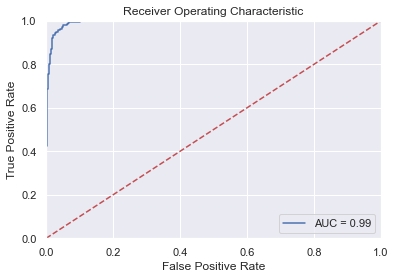

In [38]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import classification_report
print("Random Forest Accuracy: "+"{:.1%}".format(accuracy_score(y_test, y_pred)));
print("Random Forest Precision: "+"{:.1%}".format(precision_score(y_test, y_pred)));
print("Random Forest Recall: "+"{:.1%}".format(recall_score(y_test, y_pred)));
print("Classification Report:")
print(classification_report(y_test, y_pred))
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# XAI analysis
## General explainability



In [39]:
#using the parameter feature_importances of random forests used for classification
importances = optimized_rf.best_estimator_['model'].feature_importances_
indices = np.argsort(importances)

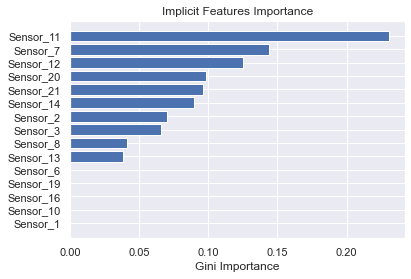

In [40]:
#Plotting the feature importance
plt.title('Implicit Features Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Gini Importance')
plt.show()
#It seems that only 10 out of the 21 initial sensors are relevant in the classification results

In [41]:
#Eli 5 library also gives the implicit feature importance of the Random Forest
import eli5
from eli5 import show_weights
eli5.explain_weights(optimized_rf.best_estimator_, feature_names=X_train.columns)

Explanation(estimator="Pipeline(steps=[('standardize', StandardScaler()),\n                ('model',\n                 RandomForestClassifier(max_depth=12, min_samples_leaf=2))])", description='\nRandom forest feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='Sensor_11', weight=0.23053226043061767, std=0.2184351814999872, value=None), FeatureWeight(feature='Sensor_7', weight=0.14409600623890692, std=0.16990806151522184, value=None), FeatureWeight(feature='Sensor_12', weight=0.12534836669781857, std=0.14818770113988952, value=None), FeatureWeight(feature='Sensor_20', weight=0.09864427993793187, std=0.13261392695847415, value=None), FeatureWeight(feature='Sensor_21', weight=0.09620649522982122, std=0.12005392705316371, value=None), FeatureWeight(feature='Sensor_14', weight=0.08966435218249673, std=0.03804412497824952, value=None), FeatureWeight(feature='Sensor_2', weight=0.07048460225797268, std=0.08896435909942452, value=None), FeatureWeight(feature='Sensor_3', weight=0.06575544335269455, std=0.08404599951591454, value=None), FeatureWeight(feature='Sensor_8', weight=0.04093413838023302, std=0.0645863228376224, value=None), FeatureWeight(feature='Sensor_13', weight=0.03829358915488605, std=0.052153346112196915, value=None), FeatureWeight(feature='Sensor_6', weight=4.0466136620719487e-05, std=0.00025142912519352114, value=None), FeatureWeight(feature='Sensor_19', weight=0.0, std=0.0, value=None), FeatureWeight(feature='Sensor_16', weight=0.0, std=0.0, value=None), FeatureWeight(feature='Sensor_10', weight=0.0, std=0.0, value=None), FeatureWeight(feature='Sensor_1', weight=0.0, std=0.0, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [48]:
#Creating a list with only important features
features=['Sensor_1','Sensor_2','Sensor_3','Sensor_6','Sensor_7','Sensor_8','Sensor_10','Sensor_11','Sensor_12','Sensor_13','Sensor_14','Sensor_16','Sensor_19','Sensor_20','Sensor_21']


In [49]:
#Feature permutation explainability technique application. 
#To explore further Feature permutation explainability, the source is recommended: Molnar, Christoph. “Interpretable machine learning. A Guide for Making Black Box Models Explainable”, 2019.
# https://christophm.github.io/interpretable-ml-book/.

from eli5.sklearn import PermutationImportance
perm=PermutationImportance(optimized_rf.best_estimator_).fit(X_train,y_train)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features)
feat_perm_df



feature    weight       std
0   Sensor_11  0.019292  0.000652
1   Sensor_14  0.016444  0.000225
2   Sensor_12  0.012433  0.000481
3    Sensor_7  0.011997  0.000323
4    Sensor_2  0.008434  0.000352
5   Sensor_20  0.008192  0.000439
6   Sensor_21  0.008168  0.000275
7    Sensor_3  0.006677  0.000197
8   Sensor_13  0.004169  0.000117
9    Sensor_8  0.003902  0.000141
10   Sensor_6  0.000012  0.000024
11  Sensor_19  0.000000  0.000000
12  Sensor_16  0.000000  0.000000
13  Sensor_10  0.000000  0.000000
14   Sensor_1  0.000000  0.000000

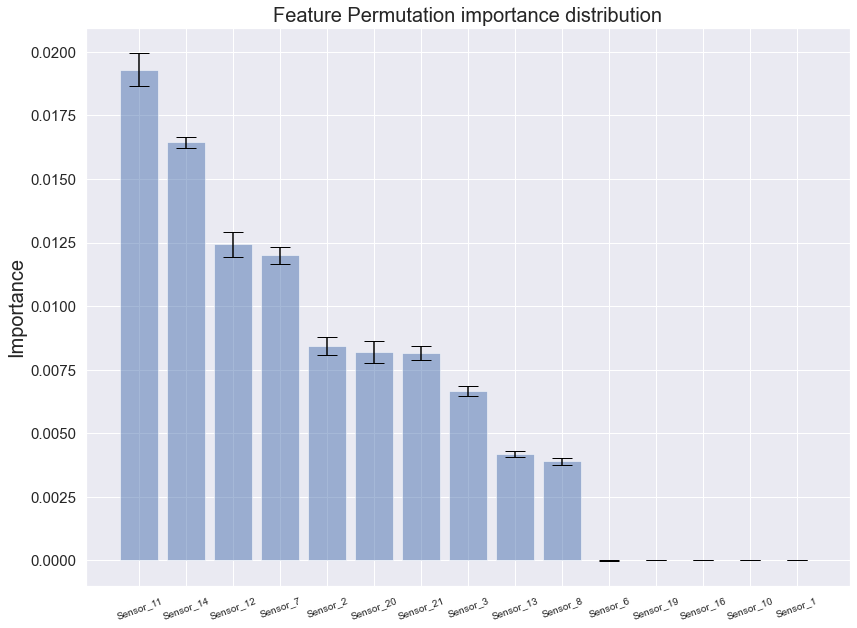

In [50]:
#%% Ploting the above table
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(feat_perm_df['feature'], feat_perm_df['weight'], yerr=feat_perm_df['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks(feat_perm_df['feature'])
ax.set_xticklabels(feat_perm_df['feature'], fontsize=8)
ax.tick_params(axis='x', which='major', labelsize=10, labelrotation=20)
ax.set_title('Feature Permutation importance distribution', fontsize=20)
ax.yaxis.grid(True)

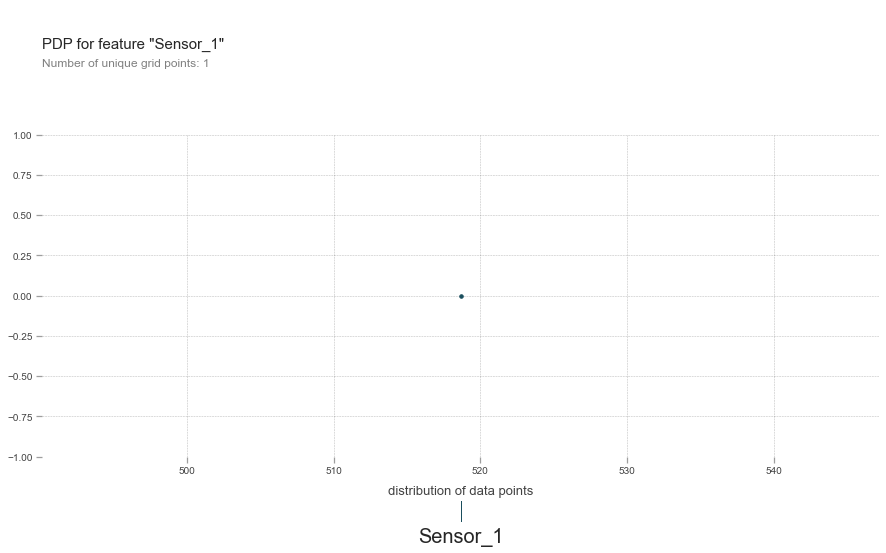

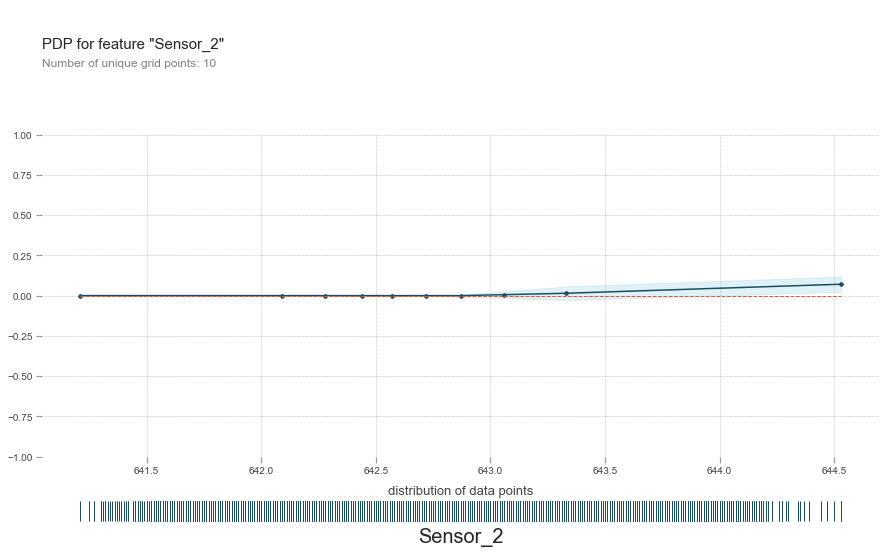

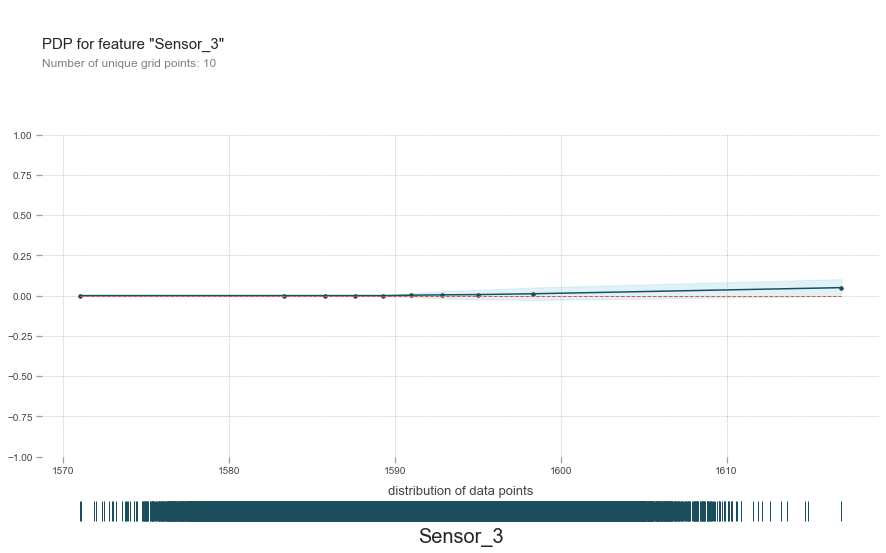

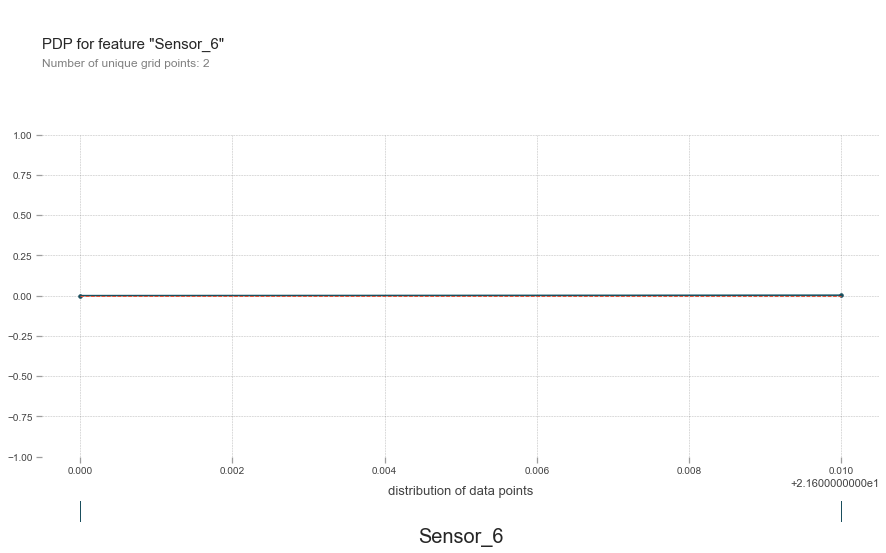

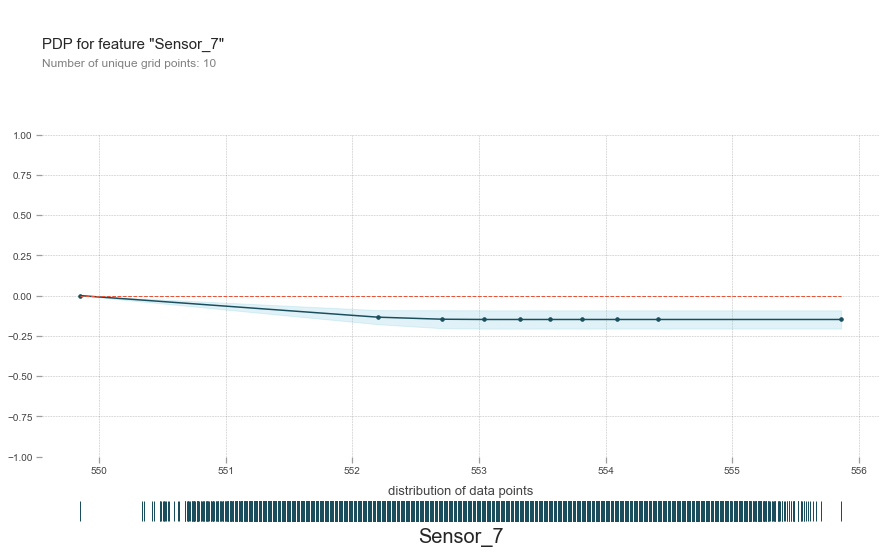

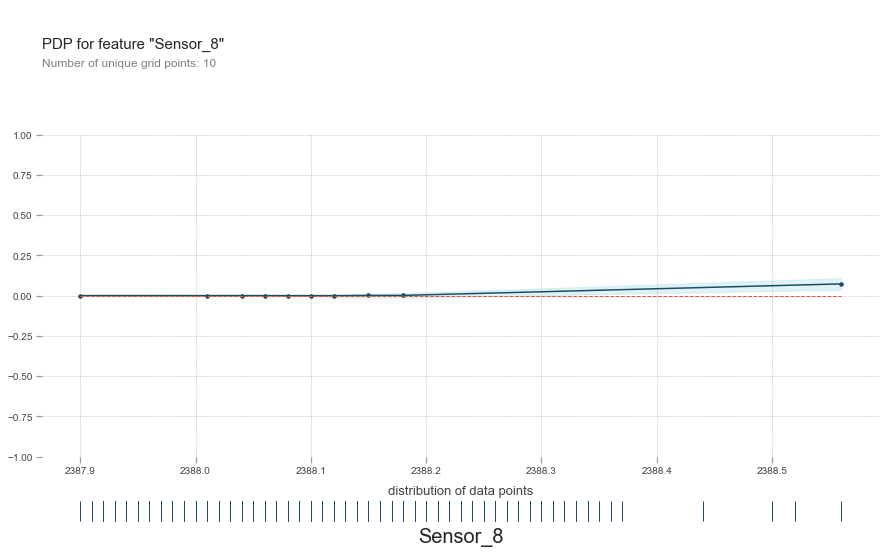

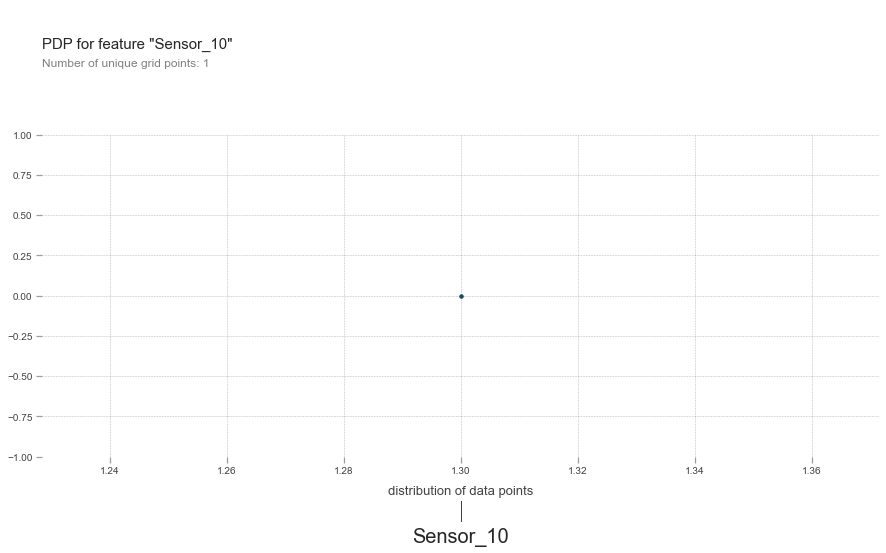

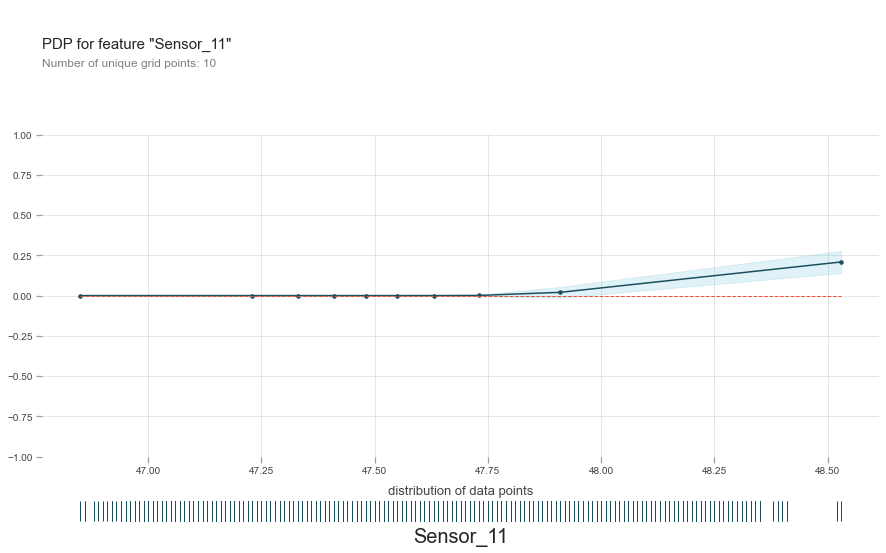

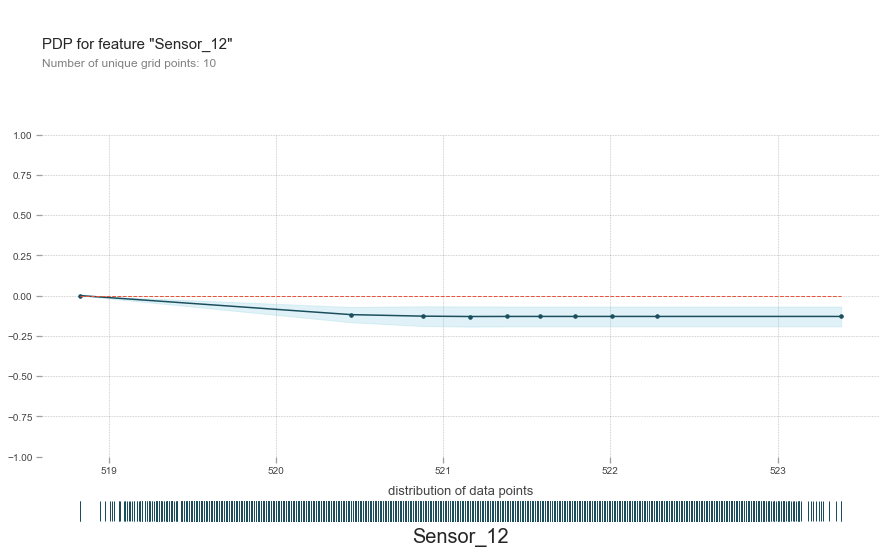

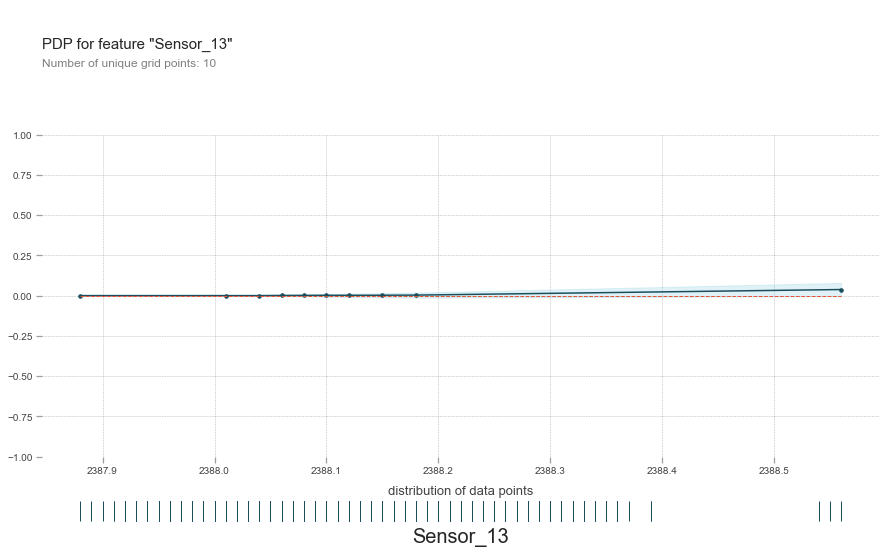

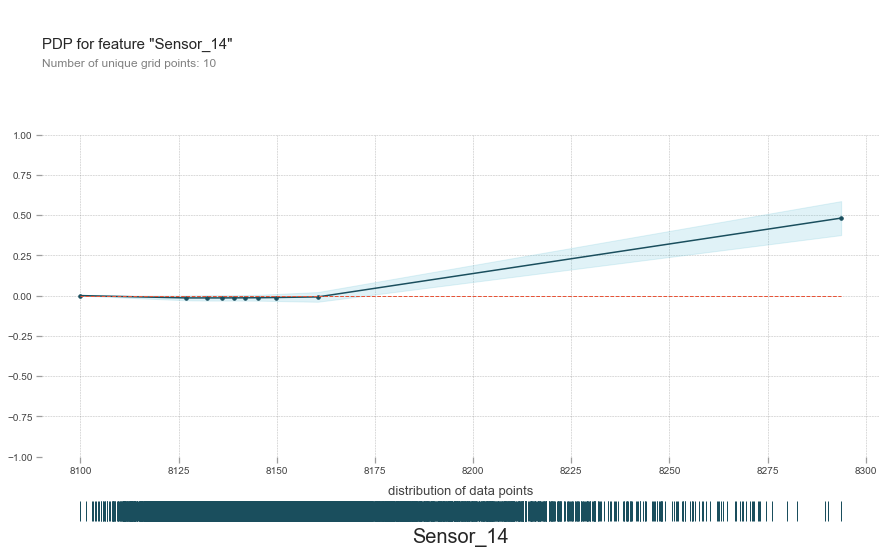

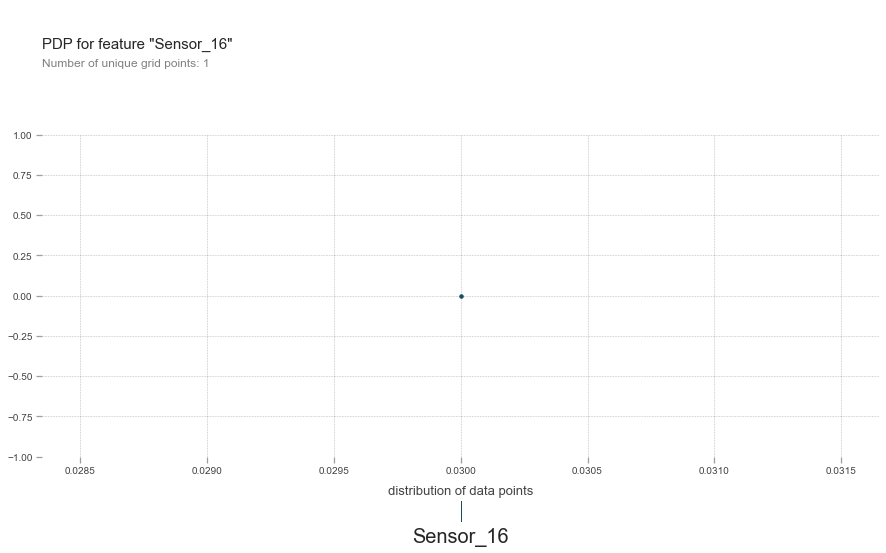

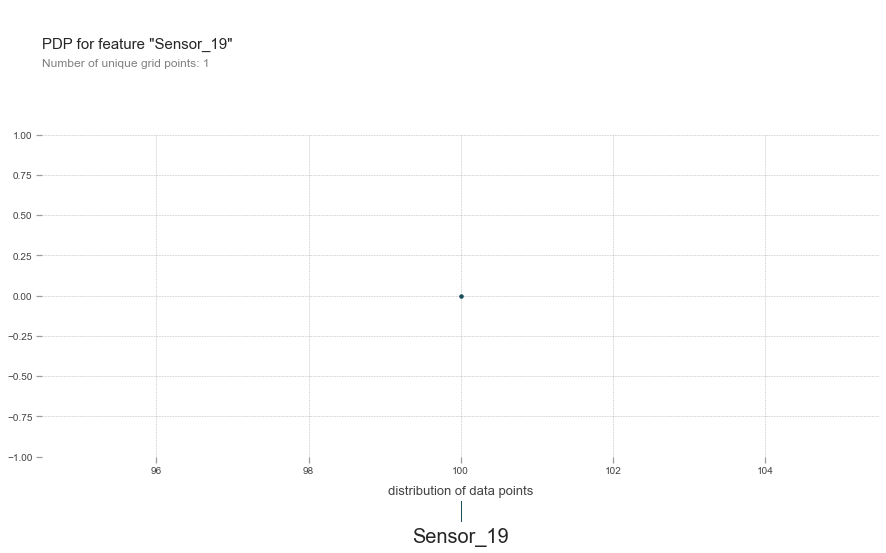

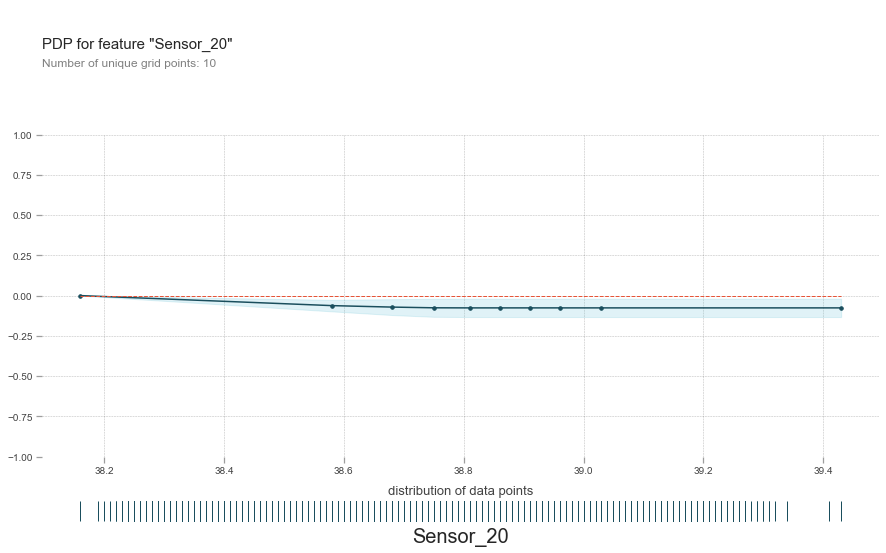

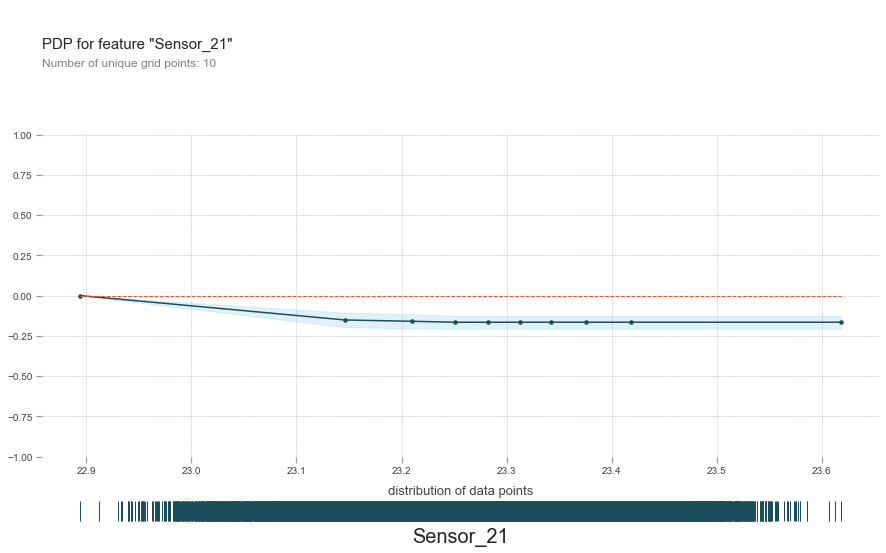

In [52]:
# Employing another type of explainability post-hoc technique Partial Dependence Plot
#Again see the reference for further information: Molnar, Christoph. “Interpretable machine learning. A Guide for Making Black Box Models Explainable”, 2019.
# https://christophm.github.io/interpretable-ml-book/.

from pdpbox import pdp, get_dataset, info_plots 
for i in X_train.columns:
    pdp_Xtrain= pdp.pdp_isolate(model=optimized_rf.best_estimator_, dataset=X_train, model_features=X_train.columns, feature=i)
    fig,axes=pdp.pdp_plot(pdp_Xtrain,i,plot_pts_dist=True, frac_to_plot=0.5)
    axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=-1, ymax=1)
    axes['pdp_ax']['_count_ax'].tick_params(axis='both', labelsize=15)
    axes['pdp_ax']['_count_ax'].set_xlabel(i, fontsize=20)
    axes['pdp_ax']['_count_ax'].set_title('distribution of data points', fontsize=13)

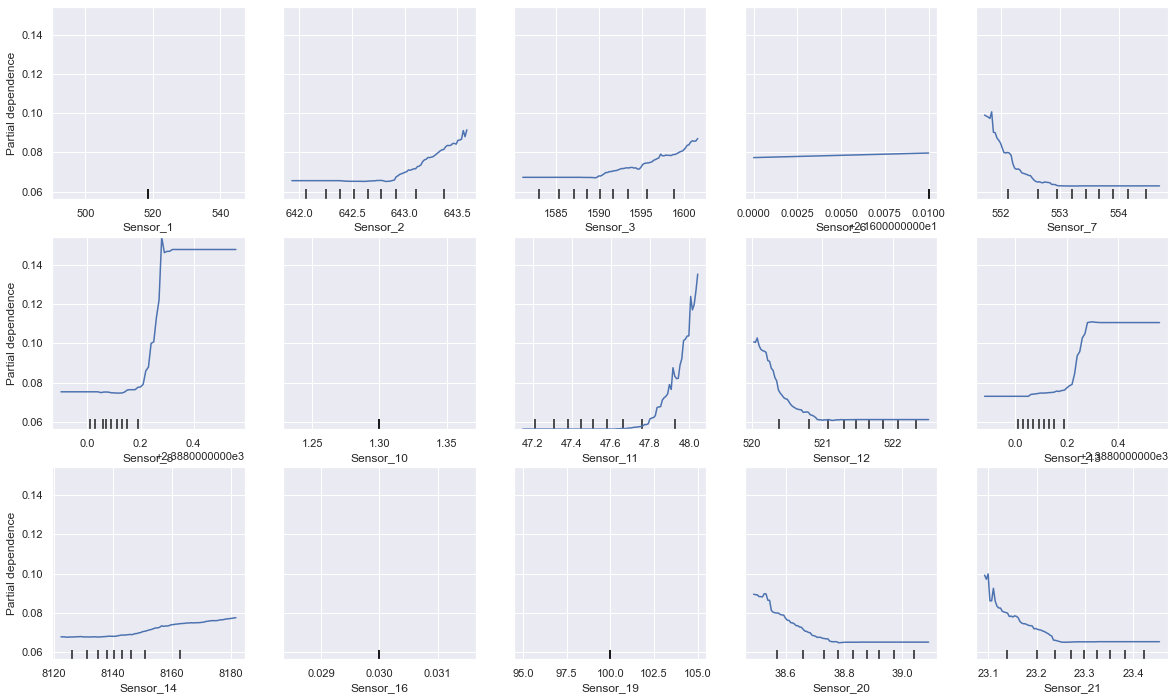

In [54]:
#Using the PDP functionality provided by sklearn
from sklearn.inspection import plot_partial_dependence
fig_train, (ax1,ax2,ax3) = plt.subplots(3, 5, figsize=(20, 12),)
pdp_train_inner=plot_partial_dependence(optimized_rf.best_estimator_, X_train,X_train.columns, ax=[ax1,ax2,ax3])



In [55]:
optimized_rf.best_estimator_

Pipeline(steps=[('standardize', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=12, min_samples_leaf=2))])

In [56]:
#Using SHAP values as another explainability technique
#Again see the reference for further information: Molnar, Christoph. “Interpretable machine learning. A Guide for Making Black Box Models Explainable”, 2019.
# https://christophm.github.io/interpretable-ml-book/.

import shap
shap.initjs()
explainer=shap.explainers.Tree(optimized_rf.best_estimator_['model'], optimized_rf.best_estimator_['standardize'].fit_transform(X_train))
shap_values=explainer.shap_values(optimized_rf.best_estimator_['standardize'].fit_transform(X_train), check_additivity=False)


100%|===================| 32998/33008 [04:48<00:00]       

In [47]:
np.shape(shap_values)

(2, 16504, 21)

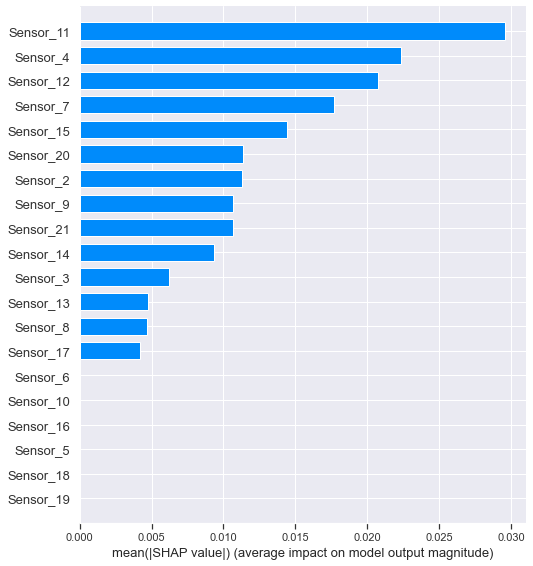

In [65]:
#Printing the global importance of the features
shap.summary_plot(shap_values[1], X_train,plot_type="bar")

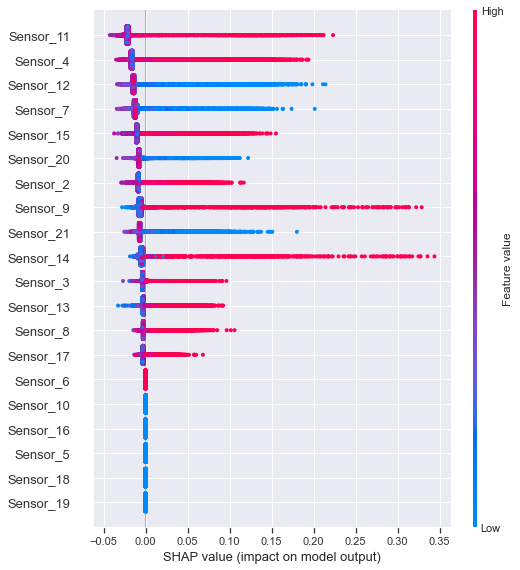

In [66]:
# The summary_plot offers enhanced information where the importance of the falues is show depending on the features values as well as the sign of the contribution to the prediction 
shap.summary_plot(shap_values[1], X_train,plot_type="dot")

In [ ]:
#The force plot offer an interactive way to assess the importance of every feature for each instance of the dataset
shap.force_plot(explainer.expected_value[1],shap_values[1], X_train[features])

## Individual explainability
### ELI5 individual explainability
### SHAP waterfall plots.

In [54]:
y_pred_train=optimized_rf.best_estimator_.predict(X_train)

SHAP individual explanation of a True Negative
predicted label 0
actual label 0


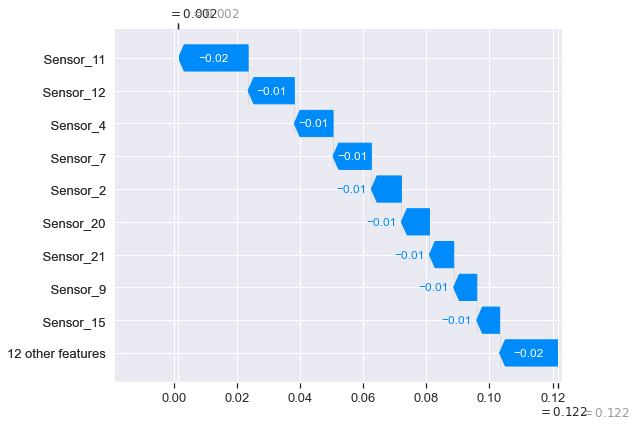

In [60]:
#SHAP also offers the possibilty to assess individual prediction. Therefore, here it is shown the individual contribution of each feature for a case of True negative prediction 
print('SHAP individual explanation of a True Negative')
print('predicted label', y_pred_train[0])
print('actual label', y_train.iloc[0])
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][0], X_train.iloc[0,:])

SHAP individual explanation of a True Negative
predicted label 1
actual label 1


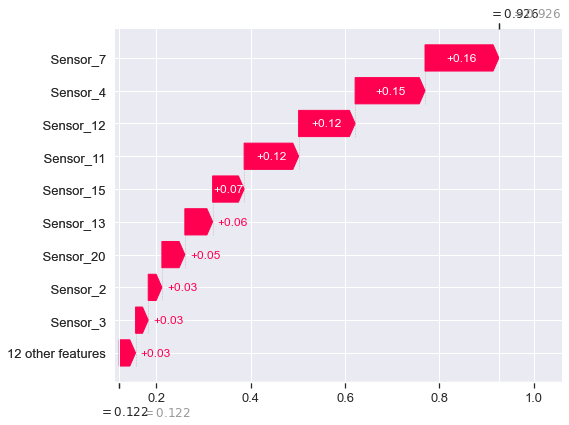

In [64]:
#On the other hand, here it is shown the individual contribution of each feature for a case of True positive prediction 
print('SHAP individual explanation of a True Negative')
print('predicted label', y_pred_train[21])
print('actual label', y_train.iloc[21])
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][21], X_train.iloc[21,:])

optimized_rf.best_estimator_
